In [5]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.sentiment import SentimentIntensityAnalyzer

In [6]:
df = pd.read_csv("C:/Users/VINAYTEJA KEASRI/OneDrive/Desktop/Reelo/TestReviews.csv")

In [7]:
df.rename(columns={'review': 'review_text'}, inplace=True)


In [8]:
print(df.columns)


Index(['review_text', 'class'], dtype='object')


In [9]:
df.dropna(subset=['review_text'], inplace=True)  # Remove NaNs
df = df[df['review_text'].str.strip() != '']     # Remove empty strings


In [10]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\VINAYTEJA
[nltk_data]     KEASRI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '',text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ',text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])  
    return text


In [13]:
df = df.copy()  
df['clean_text'] = df['review_text'].apply(clean_text)

In [14]:
df.head()

,review_text,class,clean_text
0,Fantastic spot for an even or a quite cocktail...,1,fantastic spot even quite cocktail swell host ...
1,"Love, love, love the calamari. It's so good an...",1,love love love calamari good spicy endless lis...
2,"Love this place. Stiff martinis and cocktails,...",1,love place stiff martinis cocktails cheap drin...
3,It's everything a great cocktail bar should be...,1,everything great cocktail bar great location a...
4,"I came here before a pirates game, so it was a...",1,came pirates game around ish evening gotten lu...


In [15]:
df.drop(columns=['review_text'],inplace=True)

In [16]:
df.head()

,class,clean_text
0,1,fantastic spot even quite cocktail swell host ...
1,1,love love love calamari good spicy endless lis...
2,1,love place stiff martinis cocktails cheap drin...
3,1,everything great cocktail bar great location a...
4,1,came pirates game around ish evening gotten lu...


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

def extract_themes(corpus, n_topics=3, n_words=10):
    #  Convert text to bag-of-words
    vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(corpus)

    #  Train the LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    # Extract and store top words for each topic
    topics = {}
    
    # Use this line for older versions of scikit-learn
    words = vectorizer.get_feature_names()

    for idx, topic in enumerate(lda.components_):
        top_word_indices = topic.argsort()[-n_words:][::-1]
        top_words = [words[i] for i in top_word_indices]
        topics[f"Topic {idx + 1}"] = top_words

    return topics

themes = extract_themes(df['clean_text'], n_topics=3, n_words=10)

# Display topics
print("Top Topics from Reviews:")
for topic, words in themes.items():
    print(f"{topic}: {', '.join(words)}")


Top Topics from Reviews:
Topic 1: place, time, like, dont, room, people, went, got, staff, told
Topic 2: food, place, great, good, like, really, time, bar, love, service
Topic 3: great, time, place, like, good, really, ive, best, love, nice


In [22]:
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import numpy as np

In [23]:
df['date'] = pd.to_datetime(np.random.choice(pd.date_range("2024-01-01", "2024-04-01"), len(df)))

In [24]:
df.to_csv("cleandata.csv",index = False)

[nltk_data] Downloading package vader_lexicon to C:\Users\VINAYTEJA
[nltk_data]     KEASRI\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


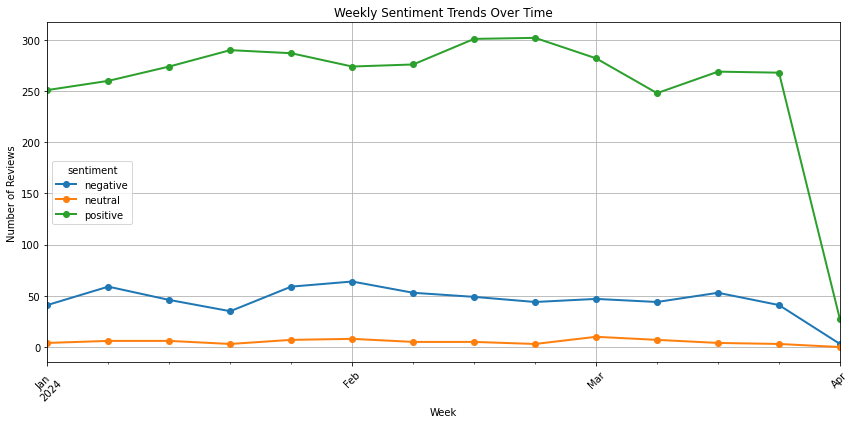

In [28]:

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
df['sentiment'] = df['clean_text'].apply(get_sentiment)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by week and sentiment counts
weekly_sentiment = df.groupby([df['date'].dt.to_period('W'), 'sentiment']).size().unstack().fillna(0)
weekly_sentiment.index = weekly_sentiment.index.to_timestamp()

# Plot
weekly_sentiment.plot(marker='o', figsize=(12,6), linewidth=2)
plt.title("Weekly Sentiment Trends Over Time")
plt.xlabel("Week")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()